In [20]:
import pandas as pd
import numpy as np
import sqlite3
import sys
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors


engine = create_engine("sqlite:///courses_2.db")
courses = pd.read_sql('''
SELECT * FROM courses;''', engine)

courses.dropna(subset=['satisfaction'],inplace=True)

courses['teaching_total'] = courses['teaching_1'] + courses['teaching_2'] + courses['teaching_3'] + courses['teaching_4']
courses['opportunities_total'] = courses['opportunities_1'] + courses['opportunities_2'] + courses['opportunities_3']
courses['feedback_total'] = courses['feedback_1'] + courses['feedback_2'] + courses['feedback_3'] + courses['feedback_4']
courses['support_total'] = courses['support_1'] + courses['support_2'] + courses['support_3']
courses['management_total'] = courses['management_1'] + courses['management_2'] + courses['management_3']
courses['resources_total'] = courses['resources_1'] + courses['resources_2'] + courses['resources_3']
courses['community_total'] = courses['community_1'] + courses['community_2'] 
courses['voice_total'] = courses['voice_1'] + courses['voice_2'] + courses['voice_3'] + courses['voice_4']


courses['teaching_mean'] = (courses['teaching_1'] + courses['teaching_2'] + courses['teaching_3'] + courses['teaching_4'])/4
courses['opportunities_mean'] = (courses['opportunities_1'] + courses['opportunities_2'] + courses['opportunities_3'])/3
courses['feedback_mean'] = (courses['feedback_1'] + courses['feedback_2'] + courses['feedback_3'] + courses['feedback_4'])/4
courses['support_mean'] = (courses['support_1'] + courses['support_2'] + courses['support_3'])/3
courses['management_mean'] = (courses['management_1'] + courses['management_2'] + courses['management_3'])/3
courses['resources_mean'] = (courses['resources_1'] + courses['resources_2'] + courses['resources_3'])/3
courses['community_mean'] = (courses['community_1'] + courses['community_2'] )/2
courses['voice_mean'] = (courses['voice_1'] + courses['voice_2'] + courses['voice_3'] + courses['voice_4'])/4

courses['teaching_min'] = courses[['teaching_1','teaching_2','teaching_3','teaching_4']].max(axis=1)
courses['opportunities_min'] = courses[['opportunities_1','opportunities_2','opportunities_3']].max(axis=1)
courses['feedback_min'] = courses[['feedback_1','feedback_2','feedback_3','feedback_4']].max(axis=1)
courses['support_min'] = courses[['support_1','support_2','support_3']].max(axis=1)
courses['management_min'] = courses[['management_1','management_2','management_3']].max(axis=1)
courses['resources_min'] = courses[['resources_1','resources_2','resources_3']].max(axis=1)
courses['community_min'] = courses[['community_1','community_2']].max(axis=1)
courses['voice_min'] = courses[['voice_1','voice_2','voice_3','voice_4']].max(axis=1)

courses['voice_min']

0        77.0
1        92.0
2        83.0
3        79.0
4        88.0
         ... 
47337    91.0
47338    72.0
47339    92.0
47340    90.0
47341    92.0
Name: voice_min, Length: 41491, dtype: float64

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, lars_path, ElasticNet, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import scipy.stats as stats

#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 


def diagnostic_plots(y_pred, y_true, resid, filestr):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();
    fig.savefig(filestr,dpi=200);

In [56]:
X_train_val, X_test, y_train_val, y_test = train_test_split(courses[[
    'teaching_mean',
    'opportunities_mean',
    'feedback_mean',
    'support_mean',
    'management_mean',
    'resources_mean',
    'community_mean',
    'voice_mean',
]], courses['satisfaction'], test_size=0.2,random_state=42)

# Simple Linear Regression

In [57]:
linear_model = LinearRegression()
linear_model.fit(X_train_val,y_train_val)
list(zip(X_train_val.columns, linear_model.coef_))

[('teaching_mean', 0.5842364610468221),
 ('opportunities_mean', 0.1063650301476461),
 ('feedback_mean', -0.05566924862629407),
 ('support_mean', 0.17658786362856166),
 ('management_mean', 0.2830725497476552),
 ('resources_mean', 0.1001648119853887),
 ('community_mean', -0.011386200870005608),
 ('voice_mean', 0.044303543140170945)]

In [58]:
linear_model.score(X_test,y_test)

0.7077194946106246

In [59]:
# Make predictions on the test set using the new model
test_set_pred = linear_model.predict(X_test)

In [60]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred)

4.536720100244992

In [61]:
r2_score(y_test, test_set_pred)

0.7077194946106246

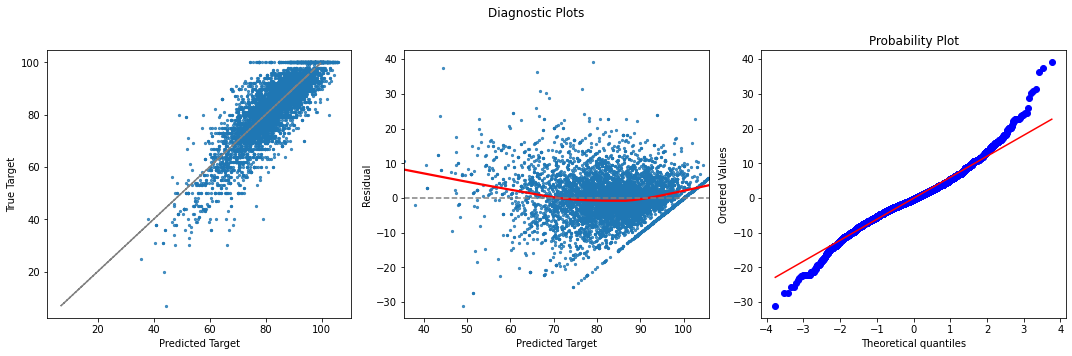

In [62]:
diagnostic_plots(test_set_pred, y_test, test_set_pred-y_test,'linear_combined_1.png')

In [45]:
poly_features = PolynomialFeatures(2).fit_transform(X_train_val)
linear_model.fit(poly_features,y_train_val)


LinearRegression()

In [46]:
linear_model.score(PolynomialFeatures(2).fit_transform(X_test),y_test)

0.7225281562737066

# Lasso

In [64]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train_val.values)
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train_val.values)
X_te = std.transform(X_test.values)
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = np.logspace(-3,2,800)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train_val);

In [65]:
# This is the best alpha value it found - not far from the value
# selected using simple validation
lasso_model.alpha_

0.001

In [66]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train_val.columns, lasso_model.coef_))

[('teaching_mean', 4.846188051366538),
 ('opportunities_mean', 0.8778321338412928),
 ('feedback_mean', -0.6150340891718139),
 ('support_mean', 1.6778591472048157),
 ('management_mean', 3.3401166172635577),
 ('resources_mean', 0.7996337050169154),
 ('community_mean', -0.12541905170220127),
 ('voice_mean', 0.46479133881329315)]

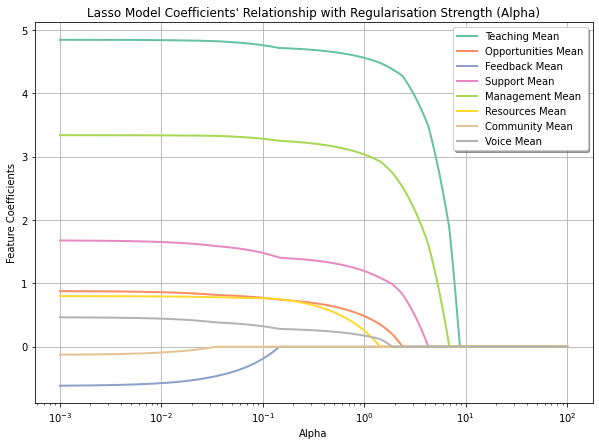

In [67]:

# #############################################################################
# Compute paths


coefs = []
for a in alphavec:
    lasso = Lasso(alpha=a)
    lasso.fit(X_tr, y_train_val)
    coefs.append(lasso.coef_)

# #############################################################################
# Display results
plt.figure(figsize=(10,7))
plt.grid()
ax = plt.gca()
ax.set_prop_cycle(color=sns.color_palette("Set2", 8))
ax.plot(alphavec, coefs,**{'linewidth':2})
# plt.axvline(x=lasso_model.alpha_,**{'color':'black','linestyle':'--'})

ax.legend([x.replace('_',' ').title() for x in list(X_train_val.columns)],shadow=True)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::])  # reverse axis
plt.xlabel('Alpha')
plt.ylabel('Feature Coefficients')
plt.title('Lasso Model Coefficients\' Relationship with Regularisation Strength (Alpha)')
plt.axis('tight')
plt.savefig('lasso_path.png',dpi=200)
plt.show()

In [51]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [52]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred)

4.536480238174812

In [53]:
r2_score(y_test, test_set_pred)

0.70781863758755

In [54]:
diagnostic_plots(test_set_pred, y_test, test_set_pred-y_test)

TypeError: diagnostic_plots() missing 1 required positional argument: 'filestr'

# Ridge

In [347]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = np.logspace(1,7,400)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr, y_train_val)
ridge_model.alpha_

34.7819065131413

In [348]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train_val.columns, ridge_model.coef_))

[('teaching_mean', 4.836979747383268),
 ('opportunities_mean', 0.8831698079643496),
 ('feedback_mean', -0.6134240573984343),
 ('support_mean', 1.6788023388811704),
 ('management_mean', 3.3369946873050456),
 ('resources_mean', 0.8010917161128747),
 ('community_mean', -0.12835156464291625),
 ('voice_mean', 0.4689202988053236)]

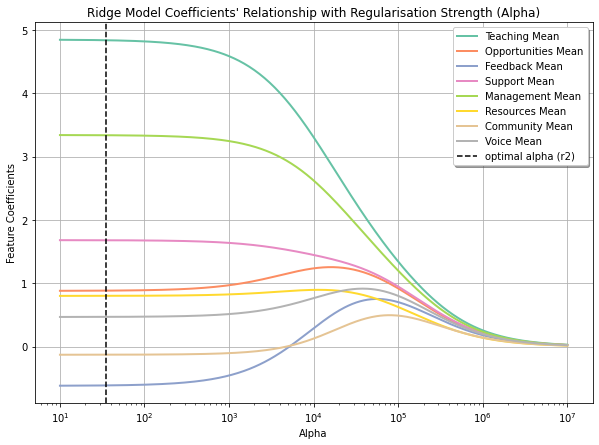

In [349]:

# #############################################################################
# Compute paths


coefs = []
for a in alphavec:
    ridge = Ridge(alpha=a)
    ridge.fit(X_tr, y_train_val)
    coefs.append(ridge.coef_)

# #############################################################################
# Display results
plt.figure(figsize=(10,7))
plt.grid()
ax = plt.gca()
ax.set_prop_cycle(color=sns.color_palette("Set2", 8))
ax.plot(alphavec, coefs,**{'linewidth':2})
plt.axvline(x=ridge_model.alpha_,**{'color':'black','linestyle':'--'})


ax.legend([x.replace('_',' ').title() for x in list(X_train_val.columns)]+['optimal alpha (r2)'],shadow=True)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::])  # reverse axis
plt.xlabel('Alpha')
plt.ylabel('Feature Coefficients')
plt.title('Ridge Model Coefficients\' Relationship with Regularisation Strength (Alpha)')
plt.axis('tight')
plt.savefig('ridge_path.png',dpi=200)
plt.show()


In [350]:
# Make predictions on the test set using the new model
test_set_pred = ridge_model.predict(X_te)

In [351]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred)

4.5369356790522986

In [352]:
r2_score(y_test, test_set_pred)

0.7077239554719377

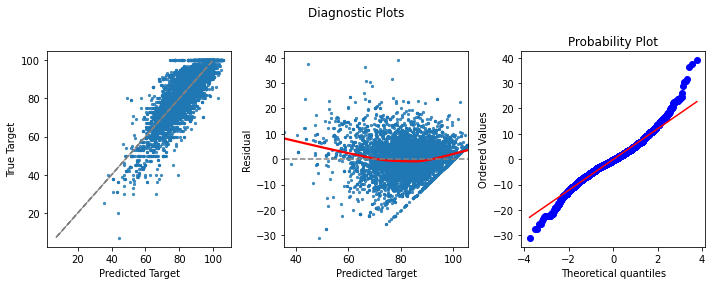

In [356]:
diagnostic_plots(test_set_pred, y_test, test_set_pred-y_test)